In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.despine()

<Figure size 432x288 with 0 Axes>

In [13]:
weather_df = pd.read_csv('~/Downloads/1643302.csv')

city_df = pd.read_csv('~/Downloads/csv-zusammenfuehren.de_7gr2scwy.csv')
city_df["AMOUNT"]=city_df["AMOUNT"].str.replace(',','')
city_df["AMOUNT"]=pd.to_numeric(city_df["AMOUNT"])

In [14]:
# cleaning the data of NAN values
# this removes ~96% of the data (snowfall and snow depth is not recorded hourly)
# data internally uses T to represent no snowfall, we will remove that as well

weather_df['DailySnowfall'].replace('T', np.nan, inplace=True)
weather_df.dropna(subset=['DailySnowfall'], inplace=True)

weather_df['DailySnowDepth'].replace('T', np.nan, inplace=True)
weather_df.dropna(subset=['DailySnowDepth'], inplace=True)

# converting the columns to numeric from object type

weather_df["DailySnowfall"]=pd.to_numeric(weather_df["DailySnowfall"], errors='ignore')
weather_df["DailySnowDepth"]=pd.to_numeric(weather_df["DailySnowDepth"], errors='ignore')

# slicing date to add a new column year
weather_df['YEAR']=weather_df['DATE'].str.slice(start=0, stop=4)

concatenated=pd.concat([weather_df.assign(dataset="weather_df"), city_df.assign(dataset="city_df")], sort=False)
#city_df

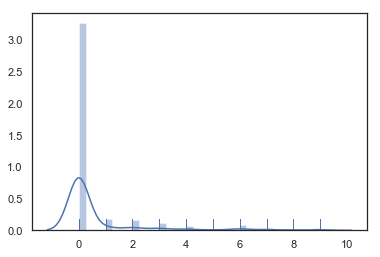

In [29]:
# lets look at the shape of the distribution of both snowfall and snow depth
val = weather_df['DailySnowDepth'].values
sns.distplot(val, rug=True, color="b");
#weather_df['DailySnowDepth'].values

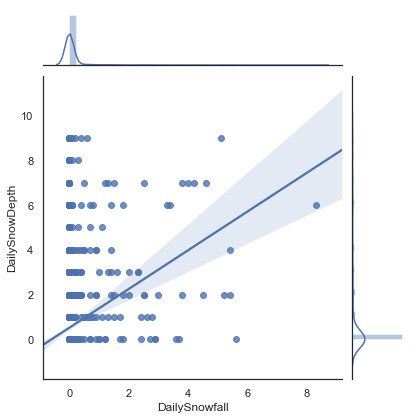

In [16]:
# 3 quartile variations of daily snowfall shown inside box
# whiskers extend to points within 1.5 inter quartiles of lower and upper bounds
# can see that there is a wide variation of snow depths that correspond to amount of daily snowfall
# there is unlikely to be much correlation

sns.jointplot(x="DailySnowfall", y="DailySnowDepth", data=weather_df, kind="reg");

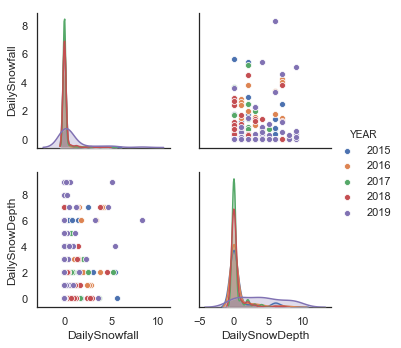

In [32]:
# another cool way to visualize this data
# we can see the distribution seems mostly random

sns.pairplot(weather_df, vars=["DailySnowfall", "DailySnowDepth"], hue="YEAR");

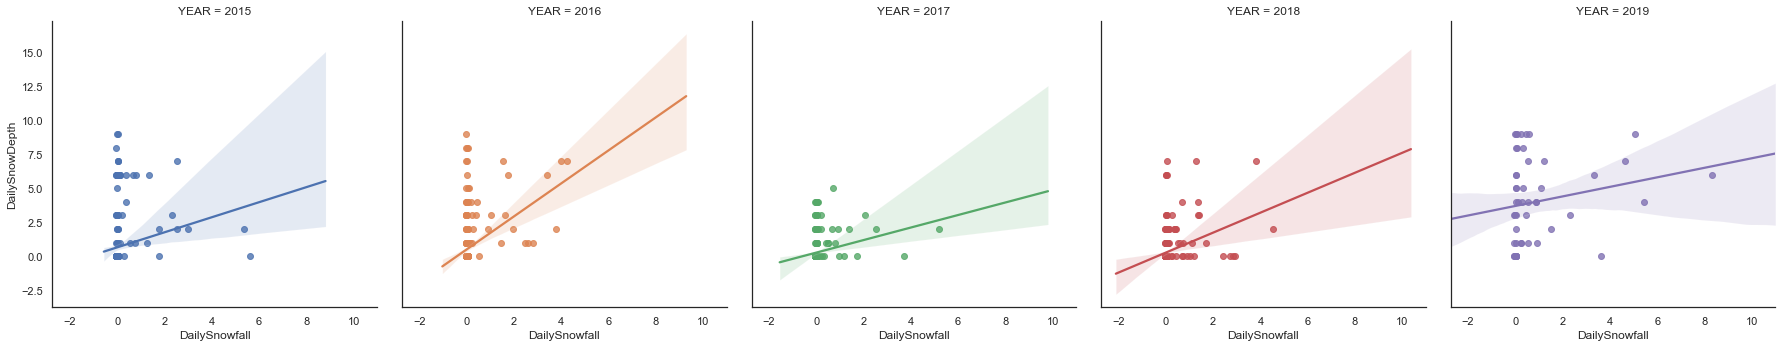

In [18]:
# just to be sure there isn't much correlation, let us look at a scatterplot of daily snowfall vs snow depth
# we can see that there is a lot of variation in this data
# 2019 does however seem to have a lot of variation which suggests scattered snowfall

ax = sns.lmplot(x="DailySnowfall", y="DailySnowDepth", data=weather_df, x_jitter=0.05, hue='YEAR', ci=95, col="YEAR")
plt;

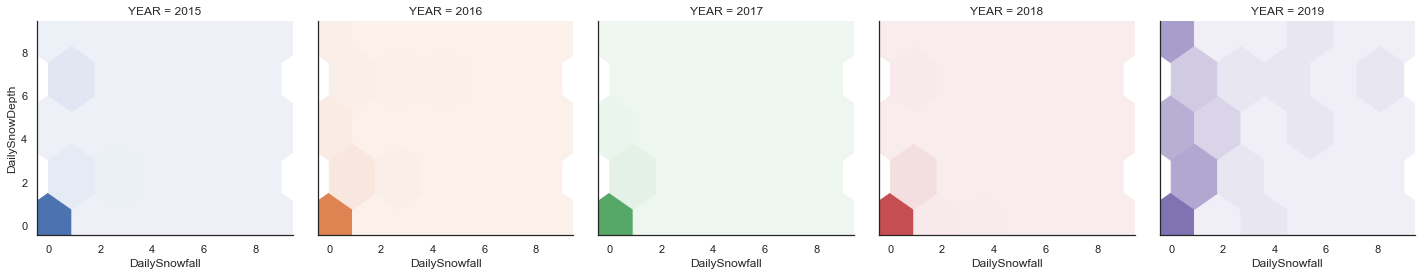

In [19]:
# thinking of different ways to visualize distribution data
# snowfall depth and daily snowfall placed in hexbins
# intensity of color corresponds to frequency
# 2019 is most random due to erratic snowfall
# seems like in 2019, snow depth accumulated due to continuous snowfall
# snowfall seemeds to be less on a single day and more dispersed in other years

def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True, n_colors=100)
    plt.hexbin(x, y, gridsize=5, cmap=cmap, **kwargs)

with sns.axes_style("white"):
    g = sns.FacetGrid(weather_df, hue="YEAR", col="YEAR", height=4)
g.map(hexbin, "DailySnowfall", "DailySnowDepth", extent=[0,9, 0,9]);

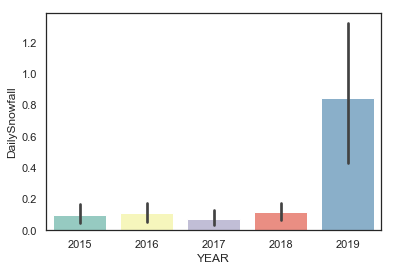

In [33]:
# lets plot the average daily snowfall for each year
# this will help us determine which years the city had to plow more intensely
# (as a high daily snowfall leads to more accumulated snow after the previous plowing)

sns.barplot(x='YEAR', y='DailySnowfall', data=weather_df, palette="Set3");

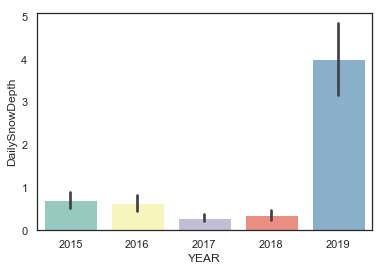

In [34]:
# lets plot the average daily snowdepth for each year
# this will also help us determine which years the city had to plow more intensely
# hopefully 2019 should be the highest again as it should have the highest snowdepth due to rapid bursts of snowfall

sns.barplot(x='YEAR', y='DailySnowDepth', data=weather_df, palette="Set3");

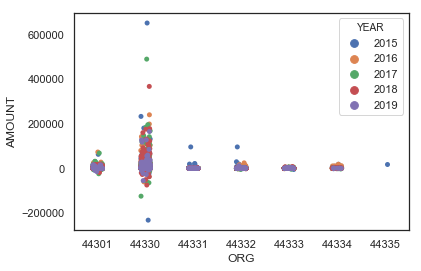

In [35]:
# plotting distribution of city data
# want to see if there is a large deviation of amount spent in transactions by a department
# we can clearly see that there is a large spread for org 44330 (Plowing)

sns.stripplot(x="ORG", y="AMOUNT", hue="YEAR", data=city_df);

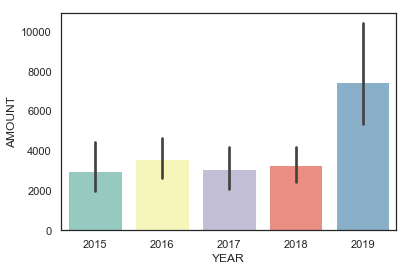

In [36]:
# lets focus closer on this department
# is there a large variation per year?
# we are plotting the average value of each plowing transaction per year
# the lines correspond to error bars that give us some insight about the uncertainity regarding each value

plow_df = city_df.loc[city_df['ORG'] == 44330]
sns.barplot(x='YEAR', y='AMOUNT', data=plow_df, palette="Set3");

# this is good since 2019 is the highest
# remember that 2019 had the highest average snowfall and snowdepth as well
# thus there seems to be a correlation between amount spent on plowing and snowfall

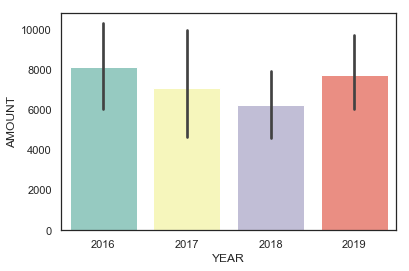

In [37]:
# now that we have narrowed down the organization to 44330 (which corresponds to Snow Plowing), lets try and get a sense
# of how funds are distributed within the organization
# a cursory glance at the objects within the organization directed my attention to the snow removal object (54260)
# the amount of money spent by this object should ideally follow the same correlation we observed in the previous chart

snow_plow_df = plow_df.loc[plow_df['OBJECT'] == 54260]
sns.barplot(x='YEAR', y='AMOUNT', data=snow_plow_df, palette="Set3");

# clearly our assumption was wrong as 2015 had the highest amount instead of 2019

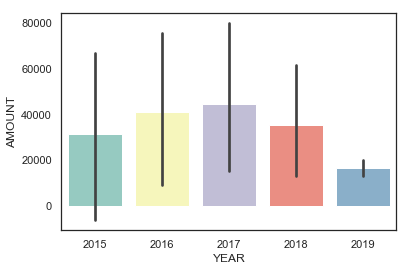

In [38]:
# lets try another object. Snow Supplies (53240) seems like a good candidate.
# The amount of snowfall should ideally correlate to the amount the city spends on supplies (salt, sand, etc.)

snow_plow_df = plow_df.loc[plow_df['OBJECT'] == 53240]
sns.barplot(x='YEAR', y='AMOUNT', data=snow_plow_df, palette="Set3");

# again, this doesn't seem to be correlated at all
# a possible explanation for this might be that the city stockpiles supplies in advance?
# this would make sense as they would be prepared well in advance for winter

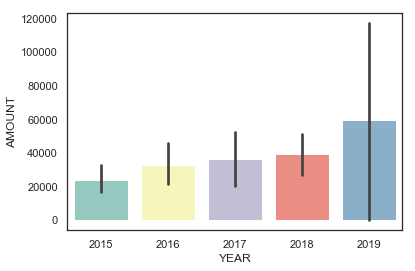

In [39]:
# lets try permanent wages next.

snow_plow_df = plow_df.loc[plow_df['OBJECT'] == 51110]
sns.barplot(x='YEAR', y='AMOUNT', data=snow_plow_df, palette="Set3");

# finally we get a clear correlation. There is a big jump from 2018 to 2019 (almost $20k in spending)
# this is definitely statistically significant as the data for January only has data up till February.
# 2 months of January 2019 resulted in more spending by the city on permanent wages than any other year in our dataset.

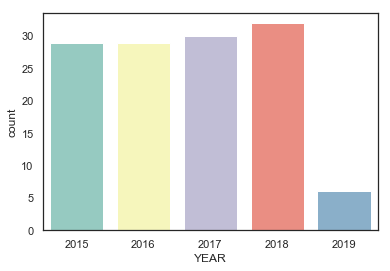

In [42]:
# now that we know that we should focus on wages, I was planning on looking at hourly wages 
# however the last data entry for hourly wages was in 2018 so I assume that it doesn't factor in the analysis

sns.countplot(x='YEAR', data=snow_plow_df, palette="Set3");

# 2019 has 5 entries yet already has more spending on permanent wages than any other year